In [3]:
### this script aims to design and train a deep learning model to estimate groundwater transmisitivy parameter across a county
### THe training data consist of hydrographical data, geomorphological data and many other categorical features presented as one hat encoder. 
### the training data also consist of the interpolation data that we obtained from Eperical Baysian Kriging for the parameter.
### the x_train data are raster, full coverage of the area like image. 
##  y_train is point observation in space so whereever there is 0 in y_train, it means that we did not have observation for that point in space. 
### the deep learning model will predict one raster which its values will be compared with the observations as loss function
### out ultimate goal is to develope a deep learning model that is capable of predicting groundwater paramwters better than Emperical Baysian Krigging. 
### The current architucture is not able to produce better than EBK.
### I have tried different architure including adding droupouts and it didnt work. 
### Some times when I use the weighting to emphesise higher value, I get good performance but it is not still better than EBL
## In general. It seems that the model reduce error a lot so that the final results have better mse than the EBK mse, but the data are skewed to small values and the image that is produced is not vicually correct. 

import os
import shutil
import math
import pyproj
import pandas as pd
import rasterio
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Activation, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.initializers import HeNormal
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from rasterio.transform import from_origin
from ml_function import kling_gupta_efficiency


def plotting_scatter(input_dataset):

    # Create 1 row, 2 columns of plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot for TRANSMSV_1
    ax1 = axes[0]
    simulated = input_dataset[input_dataset.TRANSMSV_1 > 0].Simulated_TRANSMSV_1
    observed = input_dataset[input_dataset.TRANSMSV_1 > 0].TRANSMSV_1

    # Regression line
    m, b = np.polyfit(simulated, observed, 1)
    ax1.plot(simulated, m*simulated + b, color='black', linewidth=0.5)

    R2 = r2_score(observed, simulated)
    MSE = mean_squared_error(observed, simulated)
    RMSE = math.sqrt(MSE)
    NSE = 1 - (np.sum((observed - simulated)**2) / np.sum((observed - np.mean(observed))**2))
    KGE = kling_gupta_efficiency(observed, simulated)
    PBIAS = np.sum(observed - simulated) / np.sum(observed) * 100

    ax1.scatter(simulated, observed, s=1)
    ax1.set_xlim(-1000, observed.max())
    ax1.set_ylim(-1000, observed.max())
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True value')
    ax1.set_title('EBK')

    metrics_text = f"R²: {R2:.2f}\nNSE: {NSE:.2f}\nKGE: {KGE:.2f}\nRMSE: {RMSE:.2f}\nPBIAS: {PBIAS:.2f}"
    ax1.annotate(metrics_text, xy=(0.70, 0.95), xycoords='axes fraction', verticalalignment='top')

    # Second subplot for neural network model outputs
    ax2 = axes[1]

    y_pred_flat = y_pred[0, :, :, 0].flatten()
    y_grid_flat = y_grid[0, :, :, 0].flatten()
    non_zero_indices = np.where(y_grid_flat != 0)

    y_pred_non_zero = y_pred_flat[non_zero_indices]
    y_grid_non_zero = y_grid_flat[non_zero_indices]

    # Regression line
    m, b = np.polyfit(y_pred_non_zero, y_grid_non_zero, 1)
    ax2.plot(y_pred_non_zero, m*y_pred_non_zero + b, color='black', linewidth=0.5)

    R2 = r2_score(y_grid_non_zero, y_pred_non_zero)
    MSE = mean_squared_error(y_grid_non_zero, y_pred_non_zero)
    RMSE = math.sqrt(MSE)
    NSE = 1 - (np.sum((y_grid_non_zero - y_pred_non_zero)**2) / np.sum((y_grid_non_zero - np.mean(y_grid_non_zero))**2))
    KGE = kling_gupta_efficiency(y_pred_non_zero, y_grid_non_zero)
    PBIAS = np.sum(y_grid_non_zero - y_pred_non_zero) / np.sum(y_grid_non_zero) * 100

    ax2.scatter(y_pred_non_zero, y_grid_non_zero, s=1)
    ax2.set_xlim(-1000, y_grid_non_zero.max())
    ax2.set_ylim(-1000, y_grid_non_zero.max())
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('True Values')
    ax2.set_title('CNNs')

    metrics_text = f"R²: {R2:.2f}\nNSE: {NSE:.2f}\nKGE: {KGE:.2f}\nRMSE: {RMSE:.2f}\nPBIAS: {PBIAS:.2f}"
    ax2.annotate(metrics_text, xy=(0.70, 0.95), xycoords='axes fraction', verticalalignment='top')
    plt.tight_layout()
    plt.show()
    

def prepare_cnn_data(features, target_file, cat_features, COUNTY):
    def read_raster(file_path):
        with rasterio.open(file_path) as src:
            return src.read(1)  # read the single band

    def one_hot_encode_raster(raster_data, categories):
        # Perform one-hot encoding for a single raster layer
        encoder = OneHotEncoder(categories=[categories], sparse_output=False)
        encoded = encoder.fit_transform(raster_data.reshape(-1, 1))
        return encoded.reshape(raster_data.shape + (len(categories),))

    # Reading the features and target raster files
    feature_files = [f'CNN/CNN_{feature}_raster_{COUNTY}.tif' for feature in features]
    features_data = [read_raster(file) for file in feature_files]

    # One-hot encode the categorical features
    one_hot_encoded_features = []
    for feature, raster_data in zip(features, features_data):
        if feature in cat_features:
            categories = sorted(np.unique(raster_data))  # Or provide categories explicitly
            one_hot_encoded = one_hot_encode_raster(raster_data, categories)
            one_hot_encoded_features.append(one_hot_encoded)
        else:
            one_hot_encoded_features.append(raster_data[..., np.newaxis])  # add channel axis

    # Stack features along the third axis
    X_grid = np.concatenate(one_hot_encoded_features, axis=-1)

    # Read target raster
    y_grid = read_raster(target_file)

    # Ensure the shape is compatible with CNN (add channel dimension)
    X_grid = X_grid[np.newaxis, ...]
    y_grid = y_grid[np.newaxis, :, :, np.newaxis]

    print(f'X_grid shape is {X_grid.shape}')
    print(f'y_grid shape is {y_grid.shape}')

    return X_grid, y_grid

def plotting_target_and_krigging(input_dataset, target, krigging):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Find the global min and max to use for color scaling
    vmin = min(input_dataset[krigging].min(), input_dataset[target].min())
    vmax = max(input_dataset[krigging].quantile(0.98), input_dataset[target].quantile(0.98))

    # Plot Simulated_TRANSMSV_1
    input_dataset.plot(column=krigging, s=2, cmap='Spectral_r', 
                       vmin=vmin, vmax=vmax, ax=axes[0])
    axes[0].set_title("TRANSMSV_1 krigging")
    axes[0].set_axis_off()

    # Plot TRANSMSV_1
    input_dataset.plot(column=target, s=5, cmap='Spectral_r', 
                       vmin=vmin, vmax=vmax, ax=axes[1])
    axes[1].set_title("TRANSMSV_1 observed")
    axes[1].set_axis_off()

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    sm.set_array([])
    fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')

    plt.show()
    
    
def create_rasters(input_dataset, features,COUNTY, distination_folder, res=250, crs='+proj=latlong' ):
    """
    Create raster files for each feature in the GeoDataFrame.

    Parameters:
    - input_dataset: GeoDataFrame containing the features and geometries
    - features: List of feature names to create rasters for
    - res: Resolution of the raster grid
    - crs: Coordinate Reference System string
    - folder: Output folder for the raster files

    Returns:
    None
    """
    # Define raster resolution and extent
    xmin, ymin, xmax, ymax = input_dataset.geometry.total_bounds

    # Initialize raster dimensions
    rows = int((ymax - ymin) // res) + 1
    cols = int((xmax - xmin) // res) + 1

    # Initialize raster with zeros
    array = np.zeros((rows, cols), dtype=np.float32)

    for feature in features:
        # Reset array to zeros
        if os.path.exists(f'{distination_folder}CNN_{feature}_raster_{COUNTY}.tif'):
            print(f"{distination_folder}CNN_{feature}_raster_{COUNTY}.tif already exists.")
        else:
            
            array.fill(0)

            # Fill in raster values
            for i, row in input_dataset.iterrows():
                col_idx = int((row.geometry.x - xmin) // res)
                row_idx = int((ymax - row.geometry.y) // res)
                array[row_idx, col_idx] = row[feature]


            with rasterio.open(
                f'{distination_folder}CNN_{feature}_raster_{COUNTY}.tif',
                'w',
                driver='GTiff',
                height=rows,
                width=cols,
                count=1,
                dtype=array.dtype,
                crs=pyproj.CRS.from_string("EPSG:26990").to_wkt(),
                transform=from_origin(xmin, ymax, res, res),
            ) as dst:
                dst.write(array, 1)

def plot_predicted_vs_actual(y_pred, y_actual, vmax_value=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot predicted data
    im2 = axes[0].imshow(y_pred[0,:,:,0], cmap='Spectral_r', vmax=vmax_value)
    axes[0].set_title('CNN Predicted Output')
    fig.colorbar(im2, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Plot actual data
    im1 = axes[1].imshow(y_actual[0,:,:,0], cmap='Spectral_r', vmax=vmax_value)
    axes[1].set_title('Actual Output')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.show()

def delete_all_files_in_directory(directory_path):
    """
    Deletes all files and subdirectories in the specified directory.
    
    Parameters:
        directory_path (str): The path of the directory to clear.
        
    Returns:
        None
    """
    # Check if directory exists
    if os.path.exists(directory_path):
        # List all files and directories in the directory
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            
            try:
                # If it is a file, remove it
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                # If it is a directory, remove it
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        print("The directory does not exist.")

def loading_dataset_for_CNN(COUNTY, cat_features,num_features, target_variable ):
    print('deleting previous run')
    #delete_all_files_in_directory("CNN/")
    print('loading the database....')
    try:
        os.mkdir('CNN')
    except:
        'good to go'
    input_dataset = pd.read_pickle("grid_points_well_obs_with_geometry.pk1") 
    input_dataset = input_dataset[~input_dataset.COUNTY.isna()]
    print('List of counties that you can select for extraxting data for CNN training:\n\n',input_dataset.COUNTY.unique())
    if COUNTY is not None:
        input_dataset = input_dataset[input_dataset.COUNTY==COUNTY]  #### We only want to use a subsection of the data. in this case we are limitting the dataset into Barry County. 
        input_dataset = input_dataset[input_dataset.Soil>0].reset_index(drop=True)  
    else:
        input_dataset = input_dataset[input_dataset.Soil>0].reset_index(drop=True)  
        
    input_dataset=input_dataset.fillna(0)

    # Your existing code to create rasters could follow here

    ### since we extracted a portion of the data, we have option to reset the column and row numbers as follow:
    input_dataset['Col'] = input_dataset['Col'] - input_dataset['Col'].min()+1
    input_dataset['Row'] = input_dataset['Row'] - input_dataset['Row'].min()+1

    #plotting_target_and_krigging(input_dataset, f'{target_variable}',f'Simulated_{target_variable}')

    features = [target_variable]+cat_features + num_features
    print('Creating rasters....')
    

    create_rasters(input_dataset, features, COUNTY, distination_folder='CNN/')



    # Usage
    features = cat_features + num_features  # Replace with your actual features
    target_file = f'CNN/CNN_{target_variable}_raster_{COUNTY}.tif'
        
    X_grid, y_grid = prepare_cnn_data(features, target_file, cat_features,COUNTY)
    
    return(input_dataset, X_grid, y_grid) 


def calculate_sample_weights(y_train, y_val, quantiles=[0, 25, 50, 75, 100], weights=[0.5, 1, 2, 3]):

    
    # Calculate the quantile values from y_train
    quantile_values = np.percentile(y_train[y_train > 0], quantiles)
    
    # Initialize weight arrays with ones
    sample_weight_train = np.ones_like(y_train)
    sample_weight_val = np.ones_like(y_val)
    
    # Assign weights based on the quantiles for the training set
    for i in range(len(quantiles) - 1):
        lower = quantile_values[i]
        upper = quantile_values[i + 1]
        mask = np.logical_and(y_train > lower, y_train <= upper)
        sample_weight_train[mask] = weights[i]
    
    # Assign weights based on the quantiles for the validation set
    for i in range(len(quantiles) - 1):
        lower = quantile_values[i]
        upper = quantile_values[i + 1]
        mask = np.logical_and(y_val > lower, y_val <= upper)
        sample_weight_val[mask] = weights[i]
    
    # Zero out weights where y_train or y_val is 0 or less
    sample_weight_train[y_train == 0] = 0
    sample_weight_val[y_val <= 0] = 0
    
    return sample_weight_train, sample_weight_val




def kling_gupta_efficiency_tf(y_true, y_pred, alpha=1, beta=1, gamma=1):
    # Adding epsilon to prevent division by zero
    epsilon = 1e-7
    
    mean_obs = tf.reduce_mean(y_true) + epsilon
    mean_pred = tf.reduce_mean(y_pred) + epsilon
    
    std_obs = tf.math.reduce_std(y_true) + epsilon
    std_pred = tf.math.reduce_std(y_pred) + epsilon
    
    # Calculating Pearson correlation coefficient
    r = tfp.stats.correlation(y_true, y_pred, sample_axis=None, event_axis=None) + epsilon
    
    # Calculating components
    beta_component = mean_pred / mean_obs
    gamma_component = std_pred / std_obs
    
    # Calculating KGE
    kge = 1 - tf.sqrt(tf.square(alpha * (r - 1)) + 
                     tf.square(beta * (beta_component - 1)) + 
                     tf.square(gamma * (gamma_component - 1)))
    
    return -kge  # Minimizing negative KGE is equivalent to maximizing KGE


#### Loading the database for an specific county

COUNTY='G3'

cat_features = [
    'OBJECTID_AQU_CHAR', 'OBJECTID_LDSYSTEM', 'GeologicUnit_GENERALIZE',
                'flowline', 'FCode', 'FType', 'WB','Soil','landforms' ,'landuse', 
                'StreamLeve', 'StreamOrde',
               ]  
num_features = ['Simulated_TRANSMSV_1','er_TRANSMSV_1','Simulated_TRANSMSV_2','er_TRANSMSV_2']  #

target_variable = 'TRANSMSV_1'   

input_dataset, x_grid, y_grid = loading_dataset_for_CNN(COUNTY, cat_features,num_features, target_variable)   

deleting previous run
loading the database....
List of counties that you can select for extraxting data for CNN training:

 ['Hillsdale' 'Lenawee' 'G4' 'Branch' 'St_Joseph' 'Cass' 'Berrien' 'G3'
 'Van_Buren' 'Kalamazoo' 'Oakland' 'Allegan' 'Barry' 'Macomb' 'St_Clair'
 'Genesee' 'Ionia' 'Ottawa' 'Kent' 'Lapeer' 'Gratiot' 'Muskegon'
 'Montcalm' 'G2' 'G1' 'Newaygo' 'Oceana' 'Mecosta' 'Isabella' 'Clare'
 'Lake' 'Osceola' 'Mason' 'Wexford' 'Roscommon' 'Missaukee' 'Manistee'
 'Ogemaw' 'Iosco' 'Oscoda' 'Grand_Traverse' 'Crawford' 'Kalkaska' 'Benzie'
 'Alcona' 'Leelanau' 'Otsego' 'Montmorency' 'Antrim' 'G5' 'Charlevoix'
 'Cheboygan' 'Emmet']
Creating rasters....
CNN/CNN_TRANSMSV_1_raster_G3.tif already exists.
CNN/CNN_OBJECTID_AQU_CHAR_raster_G3.tif already exists.
CNN/CNN_OBJECTID_LDSYSTEM_raster_G3.tif already exists.
CNN/CNN_GeologicUnit_GENERALIZE_raster_G3.tif already exists.
CNN/CNN_flowline_raster_G3.tif already exists.
CNN/CNN_FCode_raster_G3.tif already exists.
CNN/CNN_FType_raster_G3

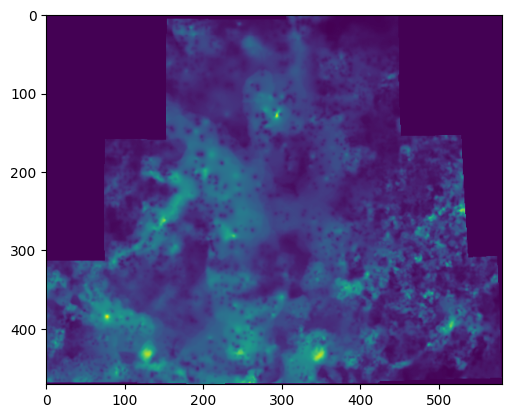

In [4]:
plt.imshow(x_grid[0,...,124])

Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 5.1834 - mean_squared_logarithmic_error: 51.6263 - val_loss: 0.0926 - val_mean_squared_logarithmic_error: 0.9228
Epoch 2/25
1/1 [==============================] - 1s 810ms/step - loss: 0.0926 - mean_squared_logarithmic_error: 0.9228 - val_loss: 0.1067 - val_mean_squared_logarithmic_error: 1.0629
Epoch 3/25
1/1 [==============================] - 1s 753ms/step - loss: 0.1067 - mean_squared_logarithmic_error: 1.0629 - val_loss: 0.0672 - val_mean_squared_logarithmic_error: 0.6691
Epoch 4/25
1/1 [==============================] - 1s 797ms/step - loss: 0.0672 - mean_squared_logarithmic_error: 0.6691 - val_loss: 0.1230 - val_mean_squared_logarithmic_error: 1.2251
Epoch 5/25
1/1 [==============================] - 1s 852ms/step - loss: 0.1230 - mean_squared_logarithmic_error: 1.2251 - val_loss: 0.0624 - val_mean_squared_logarithmic_error: 0.6219
Epoch 6/25
1/1 [==============================] - 1s 793ms/step - loss: 0.0624 - m

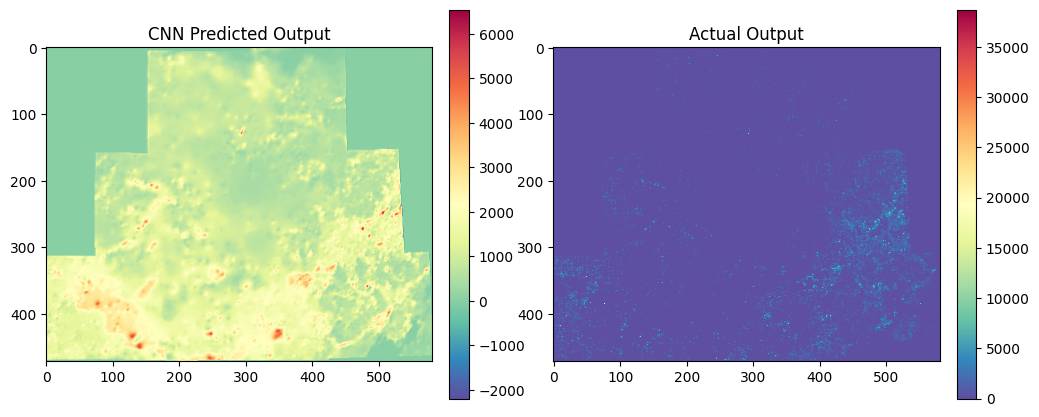

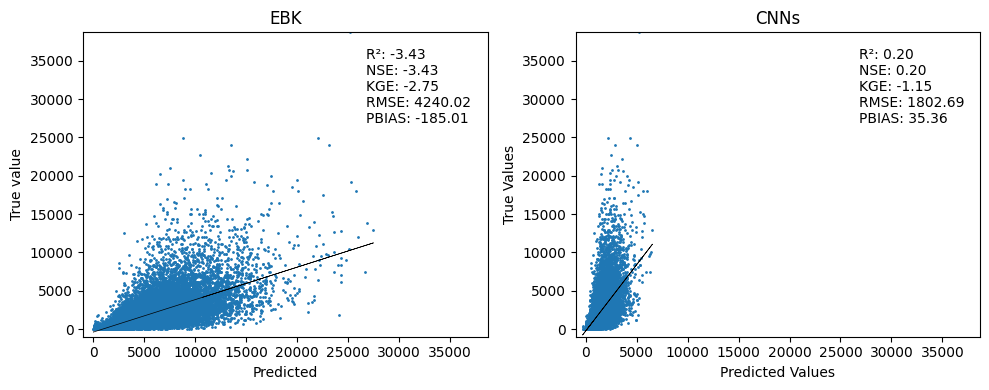

In [5]:


# Initialize early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential([
    # Initial Convolution
    Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', kernel_initializer='he_normal', input_shape=(None, None, x_grid.shape[-1])),
    
    # Convolutional block 1
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    
    Conv2D(32, kernel_size=(2, 2), activation='linear', padding='same', kernel_initializer='he_normal'),
    # Output Layer
    Conv2D(1, kernel_size=(1, 1), activation=None, padding='same')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.8
)

# Include momentum by setting the momentum parameter
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=tf.keras.losses.msle, weighted_metrics=[tf.keras.losses.msle])

sample_weight_train, sample_weight_val = calculate_sample_weights(y_grid, y_grid, weights = [1, 1, 1, 1])

history = model.fit(x_grid, y_grid, sample_weight=sample_weight_train, epochs=25, batch_size=5,
                    validation_data=(x_grid, y_grid, sample_weight_val), verbose=True, 
                   # callbacks=[early_stopping]
                   )


y_pred = model.predict(x_grid)
plot_predicted_vs_actual(y_pred, y_grid)
plotting_scatter(input_dataset)

In [28]:
from kerastuner import RandomSearch, HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
def build_model(hp):
    model = Sequential()

    # Initial Convolution
    model.add(Conv2D(filters=hp.Int('conv1_filter', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv1_kernel', values=[3, 6]),
                     activation=hp.Choice('conv1_activation', values=['relu', 'tanh', 'sigmoid', 'swish', 'selu']),
                     padding='same',
                     kernel_initializer='he_normal',
                     input_shape=(None, None, x_train.shape[-1])))

    # Convolutional block 1
    model.add(Conv2D(filters=hp.Int('conv2_filter', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('conv2_kernel', values=[3, 6]),
                     activation=hp.Choice('conv2_activation', values=['relu', 'tanh', 'sigmoid', 'swish', 'selu']),
                     padding='same',
                     kernel_initializer='he_normal'))

    # Output Layer
    model.add(Conv2D(1, kernel_size=(1, 1), activation=None, padding='same'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.mean_squared_logarithmic_error, weighted_metrics=[tf.keras.losses.mean_squared_logarithmic_error])


    return model


# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=50,  # Number of different hyperparameter combinations to try
    executions_per_trial=25,  # Number of times to train each model
    directory='output',
    project_name='Hydrological_Model')

# Begin search
tuner.search(x_train, y_train, epochs=5)


# Get the best model
model = tuner.get_best_models(num_models=1)[0]
history = model.fit(x_train, y_train, sample_weight=sample_weight_train, epochs=75, batch_size=5,
                    validation_data=(x_val, y_val, sample_weight_val), verbose=True, callbacks=[early_stopping])


y_pred = model.predict(x_grid)
plot_predicted_vs_actual(y_pred, y_grid)
plotting_scatter(input_dataset)

Trial 7 Complete [00h 00m 25s]

Best mean_squared_error So Far: 3055156.85
Total elapsed time: 00h 00m 58s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
96                |32                |conv1_filter
3                 |3                 |conv1_kernel
64                |96                |conv2_filter
5                 |3                 |conv2_kernel
selu              |None              |conv1_activation
relu              |None              |conv2_activation

Epoch 1/5
1/1 [==============================] - 0s 378ms/step - loss: 56.3914 - mean_squared_logarithmic_error: 56.3914
Epoch 2/5
1/1 [==============================] - 0s 133ms/step - loss: 16.6010 - mean_squared_logarithmic_error: 16.6010
Epoch 3/5
1/1 [==============================] - 0s 133ms/step - loss: 14.7243 - mean_squared_logarithmic_error: 14.7243
Epoch 4/5
1/1 [==============================] - 0s 144ms/step - loss: 14.7121 - mean_squared_logarithmic_error: 14.7121
Epoch 5/5
1/1 

Traceback (most recent call last):
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 261, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils.py", line 225, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils.py", line 225, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 261, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils.py", line 225, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils.py", line 225, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils.py", line 238, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\tuner_utils.py", line 209, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\keras_tuner\engine\objective.py", line 57, in get_value
    return logs[self.name]
KeyError: 'mean_squared_error'
